In [1]:
import re
import string
from unicodedata import normalize

import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import random
import gensim
import pandas as pd
import spacy
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
import numpy as np

In [2]:
nlp = spacy.load('es_core_news_sm')

In [3]:
stemmer = SnowballStemmer("spanish")

In [4]:
esp_stop = stopwords.words('spanish')
esp_stop.remove('estado')

In [5]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([stemmer.stem(word.lemma_) for word in doc if word.lemma_ not in esp_stop])
  #return ' '.join([word.lemma_ for word in doc if word.lemma_ not in esp_stop])

In [6]:
def preprocess(df, column):
  articles = df

  articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
  articles[column] = articles[column].str.strip()
  articles[column] = articles[column].str.replace('\n', ' ')
  articles[column] = articles[column].str.replace('nº', ' ')
  articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
  articles[column] = articles[column].apply(lambda x: " ".join(x.split()))
  articles[column] = articles[column].apply(lambda x: re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize("NFD", x), 0, re.I))

  articles = articles[[len(str(x).split()) > 2 for x in articles[column]]]
  return articles.reset_index(drop=True)

### Apertura archivo y preprocesamiento

In [7]:
with open("data/nc_ch_articles.txt", "r") as file:
    data = file.read()
    data = data.replace("\n", " ")
    data = re.sub("\d+", "", data)
    data = data.lower()
    list_art = data.split("--articulo--")

In [8]:
df_art = pd.DataFrame(list_art, columns = ["article"])

In [9]:
df_art_p = preprocess(df_art, "article")

In [10]:
corpus = [word_tokenize(lemmatizer(i)) for i in df_art_p["article"]]

In [11]:
dict_corpus = corpora.Dictionary(corpus)

dtm_gensim = [dict_corpus.doc2bow(i) for i in corpus]
dtm_gensim_tfidf = models.TfidfModel(dtm_gensim)[dtm_gensim]

In [12]:
ldamodel_gensim = gensim.models.ldamodel.LdaModel(
    corpus = dtm_gensim_tfidf,
    id2word = dict_corpus,
    num_topics = 8,
    random_state = 42,
    chunksize = 1000,
    passes = 10,
    alpha = 'auto'
)

In [13]:
ldamodel_gensim.print_topics(
    num_words = 15,
    num_topics = 8
)

[(0,
  '0.004*"indigen" + 0.004*"educacion" + 0.003*"remocion" + 0.003*"puebl" + 0.003*"contralori" + 0.003*"incapac" + 0.003*"entid" + 0.003*"territori" + 0.002*"renunci" + 0.002*"territorial" + 0.002*"sobrevinient" + 0.002*"banc" + 0.002*"nacion" + 0.002*"institu" + 0.002*"estatal"'),
 (1,
  '0.004*"derech" + 0.003*"trabaj" + 0.003*"colect" + 0.003*"nacion" + 0.003*"indigen" + 0.002*"puebl" + 0.002*"tierr" + 0.002*"restriccion" + 0.002*"sindical" + 0.002*"fuerz" + 0.002*"especif" + 0.002*"segur" + 0.002*"estad" + 0.002*"internacional" + 0.002*"distribucion"'),
 (2,
  '0.003*"compon" + 0.002*"forz" + 0.002*"resolucion" + 0.002*"descans" + 0.002*"oci" + 0.002*"disfrut" + 0.002*"correccional" + 0.002*"superintendent" + 0.002*"desaparicion" + 0.001*"representat" + 0.001*"observ" + 0.001*"desterr" + 0.001*"releg" + 0.001*"res" + 0.001*"desplaz"'),
 (3,
  '0.004*"derech" + 0.004*"ten" + 0.003*"person" + 0.003*"libert" + 0.003*"vid" + 0.003*"ident" + 0.003*"informacion" + 0.003*"expresion" 

In [14]:
df_topic_term = pd.DataFrame(
    ldamodel_gensim.get_topics(),
    columns = ldamodel_gensim.id2word.values(),
    index = [f'topic{i}' for i in range(ldamodel_gensim.num_topics)]
)

In [15]:
df_topic_term.sort_values(by = df_topic_term.columns.values.tolist(), ascending = False)

,activ,asegur,bien,chil,colect,condicion,constitu,cultural,deb,democraci,...,quincuagesim,rebaj,rec,reclamacion,reclamar,reconstruccion,rev,tener,tipific,transitar
topic5,0.001654,0.001651,0.000907,0.001579,0.000085,0.001448,0.000849,0.001060,0.002511,0.001287,...,0.000281,0.000103,0.000103,0.000103,0.000103,0.000129,0.000103,0.000103,0.000103,0.000103
topic6,0.001350,0.000637,0.000297,0.000482,0.000301,0.000973,0.000334,0.000345,0.000920,0.000302,...,0.000295,0.000295,0.000295,0.000295,0.000295,0.000295,0.000295,0.000295,0.000295,0.000295
topic3,0.000777,0.000891,0.000684,0.000879,0.000739,0.001081,0.000265,0.001149,0.002544,0.000410,...,0.000222,0.000222,0.000221,0.000222,0.000222,0.000221,0.000221,0.000221,0.000221,0.000222
topic7,0.000652,0.000857,0.001941,0.000335,0.000705,0.001235,0.000304,0.000414,0.001098,0.000316,...,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282,0.000282
topic1,0.000552,0.000801,0.000312,0.000661,0.002821,0.000562,0.000680,0.000316,0.001525,0.000277,...,0.000255,0.000255,0.000255,0.000255,0.000255,0.000255,0.000255,0.000255,0.000255,0.000255
topic2,0.000373,0.000369,0.000349,0.000463,0.000351,0.000354,0.000347,0.000361,0.000404,0.000346,...,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346,0.000346
topic0,0.000362,0.000494,0.000353,0.001407,0.000355,0.000593,0.000358,0.001065,0.001120,0.000655,...,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250
topic4,0.000324,0.001412,0.001805,0.000873,0.000454,0.000442,0.000271,0.003057,0.000930,0.000788,...,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269


In [16]:
# Compute Coherence Score
'''
La Métrica de Coherencia nos da una idea de cómo de coherente es un modelo en cuanto a la distribución de sus topics: cuanto más distintas sean las palabras de los topics entre sí, menos relacionados estarán los topics y más coherente será el modelo.
'''
coherence_model_lda = CoherenceModel(model=ldamodel_gensim, texts=corpus, dictionary=dict_corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
'''
Por otro lado, la Perplejidad es una medida de cuánto se sorprende el modelo cuando se le añade datos que no había visto antes.
'''
print('\nPerplexity: ', ldamodel_gensim.log_perplexity(dtm_gensim_tfidf))  # a measure of how good the model is. lower the better.


Coherence Score:  0.43627124477463886

Perplexity:  -9.7273587683398


In [17]:
def get_max(doc):
    idx, l = zip(*doc)
    return idx[np.argmax(l)] , l[np.argmax(l)]

tpc = [get_max(doc) for doc in ldamodel_gensim[dtm_gensim_tfidf]]
df_tpc = pd.DataFrame(tpc, columns =['topico', 'prop'])
df_tpc['doc'] = df_tpc.index
df_tpc[df_tpc["topico"]==1].sort_values('prop',ascending=False).head()

,topico,prop,doc
134,1,0.836609,134
54,1,0.789942,54
106,1,0.782180,106
137,1,0.731758,137
169,1,0.723596,169


In [18]:
df_tpc.sort_values('prop',ascending=False).head()

,topico,prop,doc
389,5,0.962147,389
218,5,0.957509,218
378,5,0.950008,378
385,5,0.945618,385
299,5,0.944929,299


In [19]:
df_art_p['article'][24]

'toda persona tiene derecho a la igualdad que comprende la igualdad sustantiva la igualdad ante la ley y la no discriminacion es deber del estado asegurar la igualdad de trato y oportunidades en chile no hay persona ni grupo privilegiado queda prohibida toda forma de esclavitud el estado garantiza a todas las personas la igualdad sustantiva en tanto garantia del reconocimiento goce y ejercicio de los derechos fundamentales con pleno respeto a la diversidad la inclusion social y la integracion el estado asegura la igualdad de genero para las mujeres niñas diversidades y disidencias sexuales y de genero tanto en el ambito publico como privado esta prohibida toda forma de discriminacion en especial cuando se funde en uno o mas motivos tales como nacionalidad o apatridia edad sexo caracteristicas sexuales orientacion sexual o afectiva identidad y expresion de genero diversidad corporal religion o creencia raza pertenencia a un pueblo y nacion indigena o tribal opiniones politicas o de otr

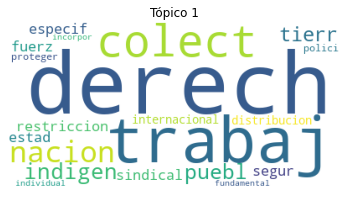

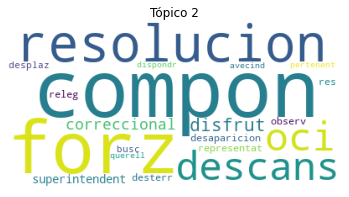

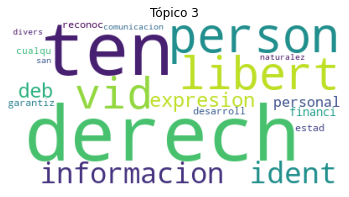

In [37]:
for i in range(1, 4):
    plt.figure()
    plt.imshow(
        WordCloud(
            background_color = 'white',
            prefer_horizontal = 1.0
        ).fit_words(dict(ldamodel_gensim.show_topic(i, 20)))
    )
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

In [42]:
index_article = random.randint(0,len(df_art_p))
df_art_p.iloc[index_article]

article    es deber del estado garantizar la democracia a...
Name: 153, dtype: object

In [43]:
dist_indices = [topic[0] for topic in ldamodel_gensim[dtm_gensim[index_article]]]
dist_contrib = [topic[1] for topic in ldamodel_gensim[dtm_gensim[index_article]]]

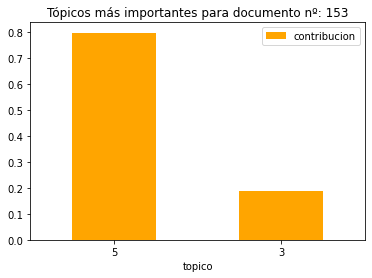

In [44]:
distribucion_topicos = pd.DataFrame({'topico':dist_indices,'contribucion':dist_contrib })
distribucion_topicos.sort_values('contribucion', ascending=False, inplace=True)

ax = distribucion_topicos.plot.bar(
    y='contribucion',
    x='topico',
    rot=0,
    color="orange",
    title = "Tópicos más importantes para documento nº: " + str(index_article)
)

In [45]:
for ind, topico in distribucion_topicos.iterrows():
    print("Topico: " + str(int(topico.topico)))
    palabras = ', '.join([palabra[0] for palabra in ldamodel_gensim.show_topic(topicid=int(topico.topico))])
    print(palabras, "\n")

Topico: 5
diput, president, regional, public, podr, funcion, region, autonom, carg, constitucion 

Topico: 3
derech, ten, person, libert, vid, ident, informacion, expresion, deb, personal 

